In [1]:
import sys

from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import logging
from asap.annotation import ASAPNMF
from asap.data.dataloader import DataSet
from asap.util import topics
import asapc

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

dl = DataSet(data_mode='sparse',data_ondisk=False)
dl.config = args
dl.initialize_path()
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [2]:
dl.load_data()
asap = ASAPNMF(adata=dl)
asap.get_pbulk()

In [3]:
asap.pbulk_mat.shape

(573, 13745)

In [4]:
K = 10
nmfm = asapc.ASAPNMFDC(asap.pbulk_mat.T,K)
nmf = nmfm.run()

In [8]:
asap.factorize()

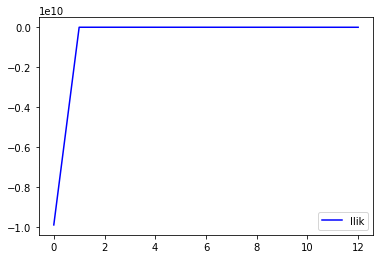

In [5]:
plt.plot(nmf.llik_trace,'b',label='llik')
plt.legend()

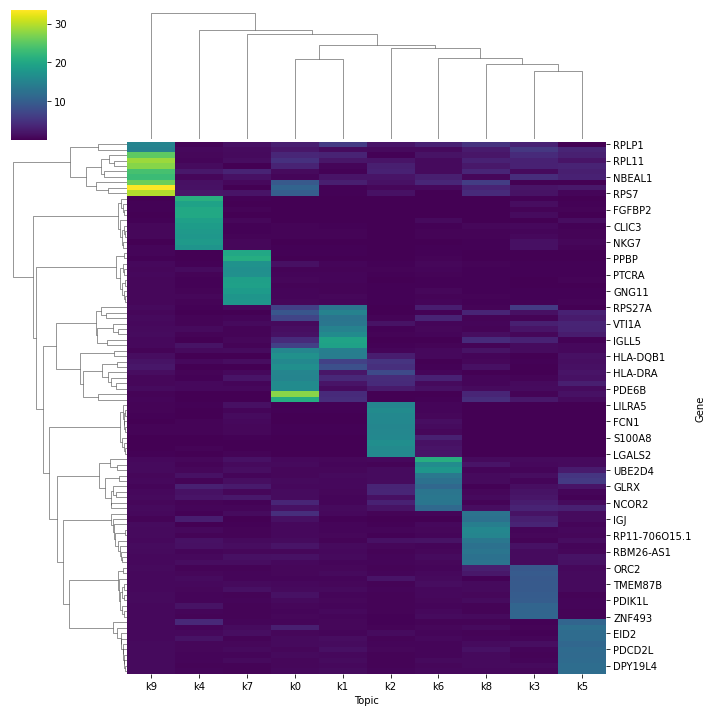

In [6]:
df_beta = pd.DataFrame(nmf.beta.T)
df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

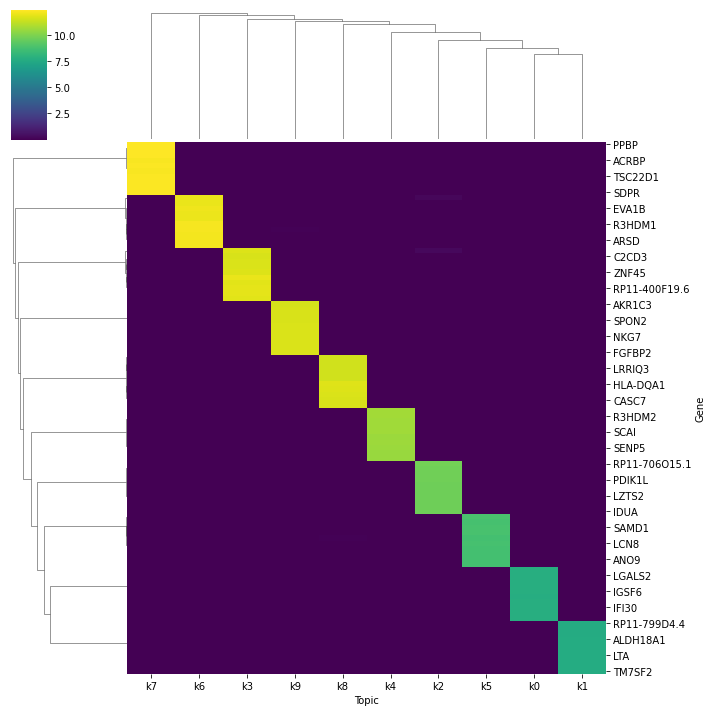

In [9]:
df_beta = pd.DataFrame(asap.model.Ebeta)
df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

In [10]:
regm = asapc.ASAPREG(dl.mtx.T,nmf.beta)
reg = regm.regress()

In [ ]:
# beta = nmf.beta
# theta = reg.B
# uu = beta.sum(0)
# beta = beta/uu
# prop = theta * uu
# zz = prop.T.sum(0).reshape(theta.shape[0],1)
# prop = prop/zz


In [11]:
import umap

df_pl = pd.read_csv(dl.outpath+'_prior_label.csv.gz')

df_theta = pd.DataFrame(reg.corr)
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap = df_umap[~df_umap['cell_type'].isna()]
df_umap



,cell,topic,umap1,umap2,cell_type
0,AAACATACAACCAC-1,9,0.655153,2.022295,CD4
1,AAACATTGAGCTAC-1,9,5.809642,-1.290988,B
2,AAACATTGATCAGC-1,9,0.115159,5.973806,CD4
3,AAACCGTGCTTCCG-1,6,13.234041,10.814548,CD14
4,AAACCGTGTATGCG-1,9,1.824403,9.929867,NK
...,...,...,...,...,...
2695,TTTCGAACTCTCAT-1,9,15.340631,9.753247,CD14
2696,TTTCTACTGAGGCA-1,9,1.003800,1.191725,B
2697,TTTCTACTTCCTCG-1,0,6.938297,-0.589447,B
2698,TTTGCATGAGAGGC-1,9,6.949278,-0.407793,B


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'dcpmf')

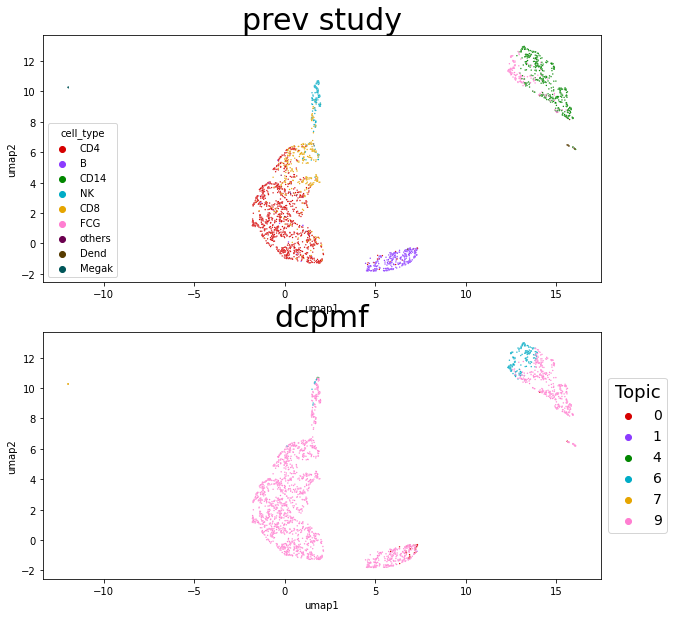

In [13]:
figure,axis = plt.subplots(2,1)
plt.rcParams["figure.figsize"] = (10,10)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=2,palette=cp,legend=True,ax=axis[0])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("prev study",fontsize=30)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic',s=2,palette=cp,legend=True,ax=axis[1])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("dcpmf",fontsize=30)